In [1]:
print("all ok")

all ok


In [2]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\Dell\Documents\automates-research-report-generation


In [3]:
from research_and_analyst.utils.model_loader import ModelLoader

In [4]:
model_loader = ModelLoader()

{"timestamp": "2025-10-12T19:09:38.169878Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2025-10-12T19:09:38.173146Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2025-10-12T19:09:38.178085Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2025-10-12T19:09:38.181137Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2025-10-12T19:09:38.183169Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2025-10-12T19:09:38.186462Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2025-10-12T19:09:38.213837Z", "level": "info", "event": "YAML config loaded"}


In [5]:
llm=model_loader.load_llm()

{"provider": "openai", "model": "gpt-4o", "timestamp": "2025-10-12T19:09:50.318951Z", "level": "info", "event": "Loading LLM"}


In [6]:
llm.invoke("hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I assist you today?'

In [7]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

#health

Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
        ),

Analyst(
    name="Dr. Arun Verma",
    role="Ethics Researcher",
    affiliation="WHO",
    description="Explores ethical implications of AI in diagnostics."
),
Analyst(
    name="Ms. Priya Sharma",
    role="Policy Analyst",
    affiliation="Ministry of Health",
    description="Investigates AI policy and compliance frameworks."
)

In [9]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

In [10]:
Analyst(
    name="Josie Ndumu",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

Analyst(name='Josie Ndumu', role='genai eng', affiliation='AI Research LAB', description='I am genai developer as well as mentor')

In [11]:
analyst = Analyst(
    name="Josie Ndumu",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [12]:
analyst.name

'Josie Ndumu'

In [13]:
analyst.role

'genai eng'

In [14]:
analyst.affiliation

'AI Research LAB'

In [15]:
print(analyst.persona)

Name: Josie Ndumu
Role: genai eng
Affiliation: AI Research LAB
Description: I am genai developer as well as mentor



In [16]:
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [17]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

In [18]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [20]:
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    ),

(Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.'),)

In [21]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [22]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']

In [23]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}
    

In [24]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 2,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Public Health Researcher', affiliation='World Health Organization', description='Dr. Emily Chen focuses on global health trends and the impact of public health policies on population health outcomes. Her primary concern is understanding how different health interventions can reduce disease burden and improve quality of life across diverse populations. She is motivated by the need to provide evidence-based recommendations to policymakers to enhance public health infrastructure and response strategies.'),
  Analyst(name='Dr. Raj Patel', role='Healthcare Technology Innovator', affiliation='MIT Media Lab', description='Dr. Raj Patel is dedicated to exploring the intersection of technology and healthcare, particularly how digital health tools can transform patient care and health management. His focus is on developing innovative solutions that leverage AI and machine learning to improve diagnostic accuracy, patient monitoring, and personali

In [25]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [26]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END


In [27]:
# def should_continue(state):
#     """ Return the next node to execute """
#     human_analyst_feedback = state.get("human_analyst_feedback",None)
#     if human_analyst_feedback:
#         return "create_analyst"

In [28]:
from IPython.display import Image, display

## First Workflow

In [29]:
builder = StateGraph(GenerateAnalystsState)

In [30]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [31]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [32]:
memory = MemorySaver()

In [33]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

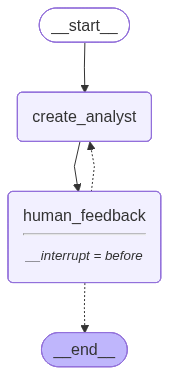

In [34]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [35]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [36]:
max_analysts = 4

In [37]:
thread =  {"configurable":{"thread_id":1}}

In [38]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            
        

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Specialist
Description: Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary interest lies in how Langgraph enhances the efficiency and scalability of AI systems. She is particularly concerned with the framework's ability to integrate with existing technologies and its potential to streamline complex AI processes.
--------------------------------------------------
Name: Michael O'Neill
Affiliation: Tech Innovations Inc.
Role: Enterprise Solutions Consultant
Description: Michael is dedicated to exploring the business benefits of Langgraph for enterprises. He examines how adopting this framework can lead to cost savings, improved productivity, and competitive advantages. His analysis often includes case studies of companies that have successfully implemented Langgraph, highlighting the framework's impact on business operations.
---------------------------

In [39]:
state = graph.get_state(thread)

In [40]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Specialist', affiliation='Institute of Advanced AI Systems', description="Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary interest lies in how Langgraph enhances the efficiency and scalability of AI systems. She is particularly concerned with the framework's ability to integrate with existing technologies and its potential to streamline complex AI processes."), Analyst(name="Michael O'Neill", role='Enterprise Solutions Consultant', affiliation='Tech Innovations Inc.', description="Michael is dedicated to exploring the business benefits of Langgraph for enterprises. He examines how adopting this framework can lead to cost savings, improved productivity, and competitive advantages. His analysis often includes case studies of companies that have successfully impleme

In [41]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Specialist', affiliation='Institute of Advanced AI Systems', description="Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary interest lies in how Langgraph enhances the efficiency and scalability of AI systems. She is particularly concerned with the framework's ability to integrate with existing technologies and its potential to streamline complex AI processes."),
  Analyst(name="Michael O'Neill", role='Enterprise Solutions Consultant', affiliation='Tech Innovations Inc.', description="Michael is dedicated to exploring the business benefits of Langgraph for enterprises. He examines how adopting this framework can lead to cost savings, improved productivity, and competitive advantages. His analysis often includes case studies of companies that have successfully implemented Langgraph, h

In [42]:
state.next

('human_feedback',)

In [43]:
# memory.storage

In [44]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0a7bf4-05ac-6a23-bfff-a89583a70b1d': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-12T23:00:30.876931+00:00\xa2id\xd9$1f0a7bf4-05ac-6a23-bfff-a89583a70b1d\xb0channel_versions\x81\xa9__start__\xd9300000000000000000000000000000001.0.3369314012271516\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0a7bf4-05bd-6be7-8000-198a91570b15': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-10-12T23:00:30.883939+00:00\xa2id\xd9$1f0a7bf4-05bd-6be7-8000-198a91570b15\xb0channel_versions\x84\xa9__start__\xd9400000000000000000000000000000002.0.47468151150889526\xa5topic\xd9400000000000000000000000000000002.0.47468151150889526\xacmax_analysts\xd9400000000000000000000000000000002.0.47468151150889526\xb8branch:to:create_analyst\xd9400000000000000000000000000000002.0.47468151150889526\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start_

In [45]:
# import msgpack

# for thread_id, ns_dict in memory.storage.items():
#     print(f"\n Thread ID: {thread_id}")
    
#     # ns_dict = defaultdict(dict, {'': {...}})
#     for ns, ckpts in ns_dict.items():
#         print(f"  Namespace: '{ns}'")
        
#         # ckpts = dict of {checkpoint_id: (packed_values, packed_metadata, parent_id)}
#         for ckpt_id, (packed_values, packed_metadata, parent_id) in ckpts.items():
#             print(f"    Checkpoint ID: {ckpt_id}")
            
#             # Decode msgpack binary
#             values = msgpack.unpackb(packed_values[1], raw=False)
#             meta = msgpack.unpackb(packed_metadata[1], raw=False)
            
#             print(f"    Values keys: {list(values.keys())}")
#             print(f"    Parent ID: {parent_id}")
#             print(f"    Metadata: {meta}")
#             print("-" * 80)


In [46]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a7bf4-476c-6c67-8001-6d5edea30d9e'}}

In [47]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a7c05-db57-676a-8002-12b4c5e062a0'}}

In [48]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Specialist
Description: Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary interest lies in how Langgraph enhances the efficiency and scalability of AI systems. She is particularly concerned with the framework's ability to integrate with existing technologies and its potential to streamline complex AI processes.
--------------------------------------------------
Name: Michael O'Neill
Affiliation: Tech Innovations Inc.
Role: Enterprise Solutions Consultant
Description: Michael is dedicated to exploring the business benefits of Langgraph for enterprises. He examines how adopting this framework can lead to cost savings, improved productivity, and competitive advantages. His analysis often includes case studies of companies that have successfully implemented Langgraph, highlighting the framework's impact on business operations.
---------------------------

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance product development cycles for new companies.
--------------------------------------------------
Name: Raj Patel
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Description: Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on how Langgraph can improve scalability, enhance data processing capabilities, and support complex workflows in multinational corporations.
--------------------------------------------------
Name: Elena Garcia
Affiliation: Institute of Advanced AI Studies
Role: AI Framework Researcher
Description: Elena's research is centered on the technical benefits of adopting Langgr

In [49]:
state = graph.get_state(thread)

In [50]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance product development cycles for new companies.'), Analyst(name='Raj Patel', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on how Langgraph can improve scalability, enhance data processing capabilities, and support complex workflows in multinational corporations.'), Analyst

In [51]:
state.next

('human_feedback',)

In [52]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance product development cycles for new companies.'),
  Analyst(name='Raj Patel', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on how Langgraph can improve scalability, enhance data processing capabilities, and support complex workflows in multinational corporations.'),
  Analyst(name='Elena G

In [53]:
# import msgpack

# def get_all_checkpoints(memory, thread_id="1"):
#     """Return all checkpoints in chronological order for a thread."""
#     checkpoints = []
#     ns_dict = memory.storage.get(thread_id, {})
#     if "" not in ns_dict:
#         return []

#     for ckpt_id, (packed_values, packed_meta, parent_id) in ns_dict[""].items():
#         values = msgpack.unpackb(packed_values[1], raw=False)
#         meta = msgpack.unpackb(packed_meta[1], raw=False)
#         checkpoints.append({
#             "id": ckpt_id,
#             "parent": parent_id,
#             "topic": values.get("topic"),
#             "feedback": values.get("human_analyst_feedback"),
#             "analyst_count": len(values.get("analysts", [])),
#             "analysts": [a.model_dump() for a in values.get("analysts", [])],
#             "step": meta.get("step"),
#             "created_at": values.get("ts", None)
#         })
#     return checkpoints

# # Fetch all
# history = get_all_checkpoints(memory)

# # Sort by step (to get chronological order)
# history = sorted(history, key=lambda x: (x["step"] or 0))

# # Display neatly
# for h in history:
#     print(f"\nSTEP {h['step']} | CHECKPOINT {h['id']}")
#     print(f"Parent: {h['parent']}")
#     print(f"Topic: {h['topic']}")
#     print(f"Feedback: {h['feedback']}")
#     print(f"Analysts generated: {h['analyst_count']}")
#     print("-"*100)


In [54]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [55]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [56]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a7c07-4d63-6aac-8006-6046c1c2395b'}}

In [57]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)


()


In [58]:
analysts = final_state.values.get('analysts')

In [59]:
analysts

[Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance product development cycles for new companies.'),
 Analyst(name='Raj Patel', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on how Langgraph can improve scalability, enhance data processing capabilities, and support complex workflows in multinational corporations.'),
 Analyst(name='Elena Garcia', role='AI Framework Researcher', affiliation='Institute of Advanced AI Studies', description="Elena's research is centered on the technical benefits of adopting Langgraph as an agent framework. She explores its archite

In [60]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on how emerging technologies like Langgraph can be leveraged by startups to gain competitive advantages. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance product development cycles for new companies.
--------------------------------------------------
Name: Raj Patel
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Description: Raj examines the integration of Langgraph within large-scale enterprise applications. His focus is on how Langgraph can improve scalability, enhance data processing capabilities, and support complex workflows in multinational corporations.
--------------------------------------------------
Name: Elena Garcia
Affiliation: Institute of Advanced AI Studies
Role: AI Framework Researcher
Description: Elena's research is centered on the technical benefits of adopting Langgr

In [61]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


## Second Workflow

In [62]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [63]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [64]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

C:\Users\Dell\AppData\Local\Temp\ipykernel_24928\1029971610.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)


In [65]:
tavily_search.invoke("langgraph")

[{'title': 'LangGraph: A Framework for Building Stateful Multi-Agent LLM ...',
  'url': 'https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03',
  'content': '> LangGraph is a powerful Python library designed for constructing stateful, multi-actor applications with Large Language Models (LLMs). It extends the capabilities of LangChain Expression Language (LCEL) while specifically addressing limitations in existing frameworks for agent development. As a specialized tool for creating complex LLM applications, LangGraph provides a structured approach to building sophisticated workflows that require cyclical processing patterns. [...] LangGraph represents a significant advancement in the toolkit available for developing sophisticated LLM applications, particularly those involving agent-like behaviors and multi-agent coordination. By extending LangChain with support for cyclical workflows and robust state management, it addresses k

In [66]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 

In [67]:
class InterviewState(BaseModel):
    pass

In [68]:
interview_builder = StateGraph(InterviewState)

In [69]:
def ask_question(state:InterviewState):
    """

    Args:
        state (InterviewState): _description_
    """
    pass


In [ ]:
def search_web(state:InterviewState):
    """

    Args:
        state (InterviewState): _description_
    """
    pass

In [ ]:
def search_wikipedia(state:InterviewState):
    """

    Args:
        state (InterviewState): _description_
    """
    pass

In [ ]:
def generate_answer(state:InterviewState):
    """

    Args:
        state (InterviewState): _description_
    """
    pass

In [ ]:
def router_messages(state:InterviewState):
    """

    Args:
        state (InterviewState): _description_
    """
    pass


In [ ]:
def save_interview(state:InterviewState):
    """

    Args:
        state (InterviewState): _description_
    """
    pass

In [ ]:
def write_section(state:InterviewState):
    """

    Args:
        state (InterviewState): _description_
    """
    pass

In [ ]:
interview_builder.add_node("ask_question",ask_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [ ]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           router_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [ ]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


In [ ]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

## third Workflow